In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [3]:
df = pd.read_csv(r"C:\Users\rabea\Desktop\deeppp\Corona_NLP_train.csv", encoding="latin1")

# שינוי שם עמודת הטקסט
df = df.rename(columns={'OriginalTweet': 'Tweet'})
from ftfy import fix_text

text_cols = ['Tweet']  # adjust to your actual text columns
for col in text_cols:
    df[col] = df[col].astype(str).map(fix_text)
df['Tweet'].iloc[81]

"Love it or hate it, head advice @10DowningStreet & @BorisJohnson \n\nBlip in our lives but it's happening!\n\n?? Don't whinge about what you can't do \n\n?? Dont panic buy as food wont run out\n\n?? DO spend time with the family\n\n?? DO use common sense\n\n#coronavirus @WorldHealthOrg2"

In [5]:
df['Tweet']=df['Tweet'].astype(str)
df['Sentiment']=df['Sentiment'].astype(str)



In [7]:
cols_to_drop = ['UserName','ScreenName','Location']
df.drop(columns=cols_to_drop, inplace=True)

In [9]:
df['Tweet'].head()

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
Name: Tweet, dtype: object

In [11]:
# Count question marks
df['QuestionMarkCount'] = df['Tweet'].str.count(r'\?')

# Count alphabetic letters only (A-Z and a-z)
df['LetterCount'] = df['Tweet'].str.count(r'[A-Za-z]')

# Drop tweets where ? > letters
num_dropped = (df['QuestionMarkCount'] > df['LetterCount']).sum()
print(f"🚮 Tweets dropped (more ? than letters): {num_dropped}")

df = df[df['QuestionMarkCount'] <= df['LetterCount']].copy()

🚮 Tweets dropped (more ? than letters): 30


In [13]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer()


def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

In [17]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
# Example: assume df has a column called 'Tweet'
# (replace with the actual column name in your dataset)

# Apply your normalization function to the whole column
df['normalized_tweet'] = df['Tweet'].astype(str).apply(normalizeTweet)

# Check the first few rows
print(df[['Tweet', 'normalized_tweet']].head(10))

                                                                                                                                                                                                                                                                                                                        Tweet  \
0                                                                                                                                                                                                             @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8   
1                                                                               advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order   
2                                    

In [19]:
df['Tweet'].iloc[80]


"Love it or hate it, head advice @10DowningStreet & @BorisJohnson \n\nBlip in our lives but it's happening!\n\n?? Don't whinge about what you can't do \n\n?? Dont panic buy as food wont run out\n\n?? DO spend time with the family\n\n?? DO use common sense\n\n#coronavirus @WorldHealthOrg2"

In [25]:
from transformers import AutoTokenizer

tweet = normalizeTweet(df['Tweet'].iloc[80])

bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

tokens = bertweet_tokenizer.tokenize(tweet)

print(tokens)

['Love', 'it', 'or', 'hate', 'it', ',', 'head', 'advice', '@USER', '&', '@USER', 'B@@', 'lip', 'in', 'our', 'lives', 'but', 'it', "'s", 'happening', '!', '?', '?', 'Do', "n't", 'wh@@', 'inge', 'about', 'what', 'you', "can't", 'do', '?', '?', 'Dont', 'panic', 'buy', 'as', 'food', 'wont', 'run', 'out', '?', '?', 'DO', 'spend', 'time', 'with', 'the', 'family', '?', '?', 'DO', 'use', 'common', 'sense', '#coronavirus', '@USER']


In [27]:
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))

Series([], dtype: int64)


In [31]:
print("Duplicate rows in df set:", df['normalized_tweet'].duplicated().sum())

Duplicate rows in df set: 35


In [33]:
dupes = df['normalized_tweet'][df['normalized_tweet'].duplicated(keep=False)]
for t in dupes.unique():
    print("\nDuplicate tweet:", t)
    print(df[df['normalized_tweet'] == t]['Tweet'].values)



Duplicate tweet: @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER
['@olson_jessie @NashTerrance @MccrorieJim @ArmyVet1775 @rogerscarmen @AliM20698746 @jimbo_always @bill_wrights @ddcampassr @JewelsJones1 @real_pat_henry @WeSeeYouWeKnow @____54_____ @RandallKraft @DatoFreddy @LennyInnecken6 @SanMateogirl11 @brandyls76 @Spa'
 '@SnapeyWapey @d_ast777 @Chrissy_Clarke @halo_scot @blackwell_dgf @DellOlioMario @AstralWarriorVT @CornerWriting @tracyjh8 @GeorgeYuhasz @StephenKing @honeycakebooks @WriteEthan @magnolia3169 @AlexaSommers @DanielaRLovejoy @nikki_twisted @MKBeker @AJUrbane'
 '@unwitod @intersexfacts @vb02md @RadFemme74 @EReality01 @Jesin00 @babybeginner @feministleaning @PheeberWeaver @CaseyRHayes @JenkinsSharing @Technicallyowen @ForeverMagdalen @ILoveUTigerLily @EmilyBanting1 @Annie26056655 @catdebuque @sclibearian @LisaTMul'
 '@MarilynLavala @77MARKALLENSOVA @kay89266490 @Consofcooking1 @MountainAjax @MsDayglo @rux

In [35]:
before = len(df)
df = df.drop_duplicates(subset=['normalized_tweet'], keep='first').reset_index(drop=True)
print(f"Removed {before - len(df)} exact duplicate rows.")

Removed 35 exact duplicate rows.


In [41]:
from langdetect import detect, DetectorFactory
import pandas as pd

# Step 1: Ensure reproducibility (langdetect is nondeterministic by default)
DetectorFactory.seed = 0

# Step 2: Define a function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return "error"

# Step 3: Apply language detection on the tweets (no modification!)
df['DetectedLang'] = df['normalized_tweet'].apply(detect_language)

# Step 4: Filter and show non-English tweets
non_english_tweets = df[df['DetectedLang'] != 'en']

print("🌐 Example Non-English Tweets (showing 20):\n")
for i, tweet in enumerate(non_english_tweets['normalized_tweet'].head(20), 1):
    print(f"{i}. {tweet}\n")

🌐 Example Non-English Tweets (showing 20):

1. @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER

2. Student resources during COVID - 19 HTTPURL

3. Une centaine de personnes se pressent aux portes d'un supermarché à Saint-Denis , en banlieue parisienne , au lendemain de l'annonce du Président Macron renforçant les restrictions de déplacement face au #covid_19 #AFP HTTPURL

4. Esto es un Carrefour antes de abrir . ¡ ¡ ¡ Viva las personas ! ! ! #YoMeQuedoEnCasa HTTPURL

5. This is just madness ! ! HTTPURL

6. For more updates , visit HTTPURL HTTPURL

7. La fin du monde ? ? HTTPURL

8. Zásah policie proti spekulant ? m s rouškami . Na m ? j popud hejtman Ústeckého kraje ve spolupráci s @USER podle krizového zákona zajistil tém ? ? 700 tis . roušek od firmy , která je m ? la dodat na zdravotník ? m , ale na poslední chvíli se snažila navyšovat cenu . #spolutozvladneme

9. ILKESTON ROAD RADFORD SHOP RIPPING PUBLIC OFF PARACETA

In [43]:
non_english_tweets['normalized_tweet'].count()

188

Tokenizing: 100%|██████████| 41092/41092 [00:23<00:00, 1724.59it/s]


count    41092.000000
mean        47.060547
std         17.024877
min          3.000000
25%         34.000000
50%         48.000000
75%         60.000000
max        140.000000
dtype: float64

Percentiles:
50th percentile: 48
75th percentile: 60
90th percentile: 68
95th percentile: 73
99th percentile: 85
100th percentile: 140


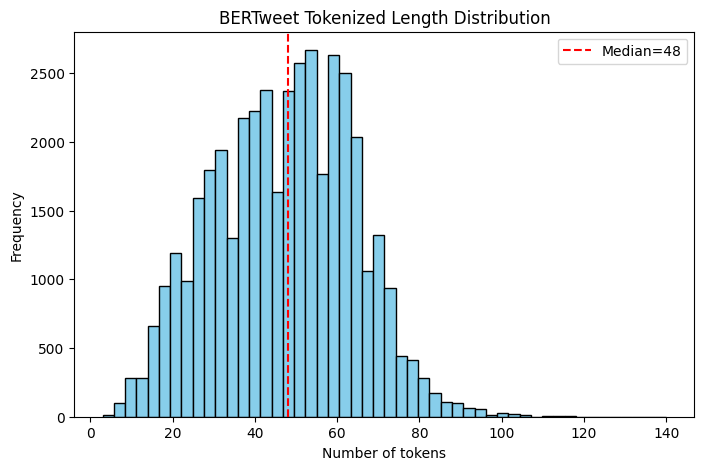

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm import tqdm

# 1) Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", use_fast=False)

# 2) Column to check (use your cleaned column)
text_col = "normalized_tweet"  # replace with the name of your cleaned text column

# 3) Get tokenized lengths
lengths = []
for txt in tqdm(df[text_col], desc="Tokenizing"):
    if isinstance(txt, str) and txt.strip():
        ids = tokenizer(txt)["input_ids"]
        lengths.append(len(ids))
    else:
        lengths.append(0)  # handle NaNs/empties

# 4) Convert to Series for easy stats
lengths_series = pd.Series(lengths)

# 5) Summary stats
print(lengths_series.describe())
print("\nPercentiles:")
for p in [50, 75, 90, 95, 99, 100]:
    print(f"{p}th percentile: {lengths_series.quantile(p/100):.0f}")

# 6) Plot distribution
plt.figure(figsize=(8,5))
plt.hist(lengths_series, bins=50, color='skyblue', edgecolor='black')
plt.title("BERTweet Tokenized Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.axvline(lengths_series.median(), color='red', linestyle='--', label=f"Median={lengths_series.median():.0f}")
plt.legend()
plt.show()

In [49]:
df.to_csv("my_eda.csv", index=False)

Tokenizing: 100%|██████████| 41092/41092 [00:35<00:00, 1159.08it/s]


count    41092.000000
mean        46.722428
std         16.802370
min          3.000000
25%         34.000000
50%         48.000000
75%         60.000000
max        147.000000
dtype: float64

Percentiles:
50th percentile: 48
75th percentile: 60
90th percentile: 68
95th percentile: 72
99th percentile: 82
100th percentile: 147


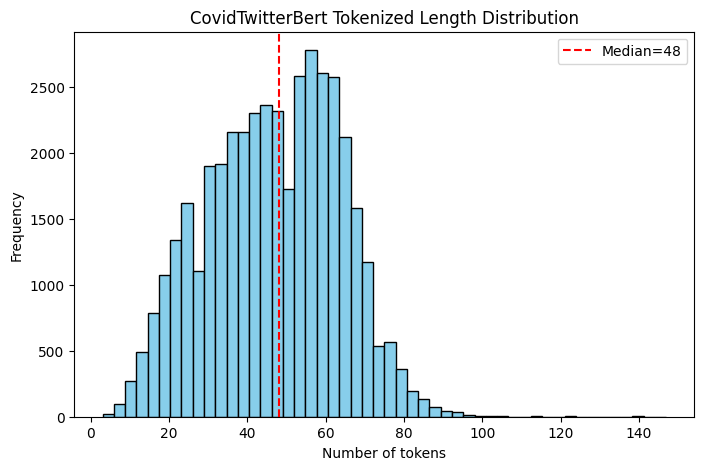

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm import tqdm

# 1) Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert", use_fast=False)

# 2) Column to check (use your cleaned column)
text_col = "normalized_tweet"  # replace with the name of your cleaned text column

# 3) Get tokenized lengths
lengths = []
for txt in tqdm(df[text_col], desc="Tokenizing"):
    if isinstance(txt, str) and txt.strip():
        ids = tokenizer(txt)["input_ids"]
        lengths.append(len(ids))
    else:
        lengths.append(0)  # handle NaNs/empties

# 4) Convert to Series for easy stats
lengths_series = pd.Series(lengths)

# 5) Summary stats
print(lengths_series.describe())
print("\nPercentiles:")
for p in [50, 75, 90, 95, 99, 100]:
    print(f"{p}th percentile: {lengths_series.quantile(p/100):.0f}")

# 6) Plot distribution
plt.figure(figsize=(8,5))
plt.hist(lengths_series, bins=50, color='skyblue', edgecolor='black')
plt.title("CovidTwitterBert Tokenized Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.axvline(lengths_series.median(), color='red', linestyle='--', label=f"Median={lengths_series.median():.0f}")
plt.legend()
plt.show()